# Practice Case Machine Learning - Iykra Week 4
## Customer Segementation and Market Basket Analysis

**Customer segmentation** is the process of dividing customers into groups based on common characteristics, so company can market to each group differently and focus on what each kind of customer needs at any given moment. In this practice case, I will use K-means clustering algorithm.  

**Market Basket Analysis** is techniques to identify relationships between the items that customer buy. This information is used by company/store to place products frequently sold together into the same area, and also to determine what new products to offer their prior customers. I will use apriori algorithm.  

**Dataset** from kaggle https://www.kaggle.com/puneetbhaya/data.   

## Load Data and Cleansing

In [5]:
#Import pandas, read and show the dataset
import pandas as pd
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
#Check the type of variables
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [7]:
#Change the type of Customert ID to string
df['CustomerID']=df['CustomerID'].astype('str')
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [8]:
#Check the statistical summary of numerical variable
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [9]:
#There are negative value in numerical variable from above statistical summary
#Check the percentage of negative value in numerical variable
df_neg = df[(df['Quantity']<0) | (df['UnitPrice']<0)]
df_neg['Quantity'].count()/len(df['Quantity'])

0.019608458246679793

In [10]:
#Since the percentage of negative value in numerical variable only 1.9%, so remove these rows
df_pos = df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df_pos.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Exploratory Data Analysis

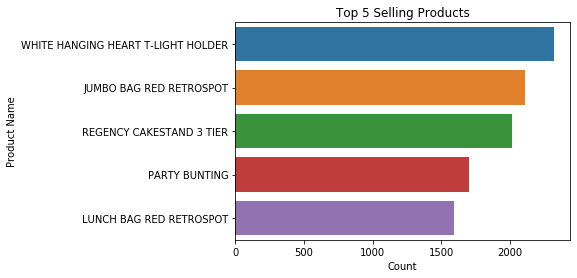

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 5 selling products
sns.countplot(y = df_pos['Description'], order = df_pos['Description'].value_counts().iloc[:5].index)
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.title('Top 5 Selling Products')
plt.show()

In [12]:
#check interval year
df_pos['InvoiceDate'].dt.year.unique()

array([2010, 2011], dtype=int64)

In [13]:
#In 2010 only have 1 month 
df_pos_2010 = df_pos[df_pos['InvoiceDate'].dt.year==2010]
df_pos_2010['InvoiceDate'].dt.month.unique()

array([12], dtype=int64)

In [14]:
#In 2011 have complete month
df_pos_2011 = df_pos[df_pos['InvoiceDate'].dt.year==2011]
df_pos_2011['InvoiceDate'].dt.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

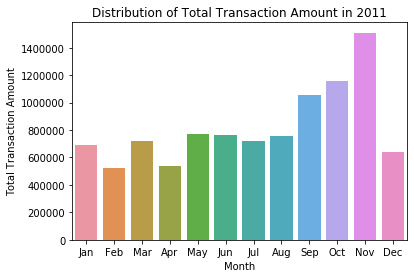

In [15]:
#Total transaction amount in each of month in 2011
sns.barplot(x = df_pos_2011['InvoiceDate'].dt.strftime('%b'), 
            y = df_pos_2011['Quantity']*df_pos_2011['UnitPrice'], 
            estimator = sum, 
            ci = None)
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')
plt.title('Distribution of Total Transaction Amount in 2011')
plt.show()

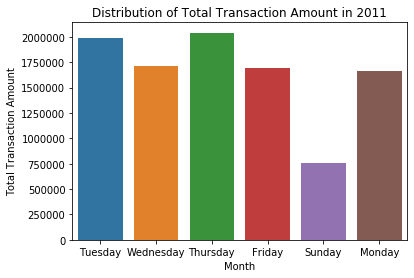

In [16]:
#Total transaction amount in each day of week in 2011
sns.barplot(x = df_pos_2011['InvoiceDate'].dt.strftime('%A'), 
            y = df_pos_2011['Quantity']*df_pos_2011['UnitPrice'], 
            estimator = sum,
            ci = None)
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')
plt.title('Distribution of Total Transaction Amount in 2011')
plt.show()

## Customer Segmentation

I create RFM variables and will be used for k-means clustering.  

Recency, time since last order for each customer.  
Frequency, total number of transaction for each customer.  
Monetary, total amount of transaction for each customer.  

In [17]:
#create monetary variable
df_pos['Monetary'] = df_pos['Quantity']*df_pos['UnitPrice']
df_pos.head()

C:\Users\Azmul Azmi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [18]:
#create recency variable with reference date is the last date of customer transaction plus 1 day
import datetime

ref_date = df_pos['InvoiceDate'].max() + datetime.timedelta(days = 1)

df_pos['Recency'] = ref_date - df_pos['InvoiceDate']
df_pos['Recency'] = df_pos['Recency'].astype('timedelta64[D]')
df_pos.head()

C:\Users\Azmul Azmi\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Azmul Azmi\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,374.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,374.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374.0


In [19]:
#Since each customer can have more than one transactions, so perform groupping.
#for recency variable, take the minimal value (time since last order)
df_pos_g = df_pos.groupby('CustomerID', as_index=False).agg({'Quantity':'count', 'Monetary':'sum', 'Recency':'min'})
df_pos_g

,CustomerID,Quantity,Monetary,Recency
0,12346.0,1,7.718360e+04,326.0
1,12347.0,182,4.310000e+03,2.0
2,12348.0,31,1.797240e+03,75.0
3,12349.0,73,1.757550e+03,19.0
4,12350.0,17,3.344000e+02,310.0
...,...,...,...,...
4334,18281.0,7,8.082000e+01,181.0
4335,18282.0,12,1.780500e+02,8.0
4336,18283.0,756,2.094880e+03,4.0
4337,18287.0,70,1.837280e+03,43.0


In [20]:
#There is one 'nan' id in customer, so remove this row
df_pos_g[df_pos_g['CustomerID']=='nan']

,CustomerID,Quantity,Monetary,Recency
4338,nan,132220,1.755277e+06,1.0


In [21]:
#Rename the columns name
df_final = df_pos_g[df_pos_g['CustomerID']!='nan']
df_final = df_final.rename(columns={'Quantity':'Frequency (Number)','Monetary':'Monetary (Total)', 'Recency': 'Recency (Day)'})
df_final

,CustomerID,Frequency (Number),Monetary (Total),Recency (Day)
0,12346.0,1,77183.60,326.0
1,12347.0,182,4310.00,2.0
2,12348.0,31,1797.24,75.0
3,12349.0,73,1757.55,19.0
4,12350.0,17,334.40,310.0
...,...,...,...,...
4333,18280.0,10,180.60,278.0
4334,18281.0,7,80.82,181.0
4335,18282.0,12,178.05,8.0
4336,18283.0,756,2094.88,4.0


In [22]:
#Remove CustomerID to perform scale and k-means clustering algorithm
df_rfm = df_final.drop(['CustomerID'], axis = 1)
df_rfm

,Frequency (Number),Monetary (Total),Recency (Day)
0,1,77183.60,326.0
1,182,4310.00,2.0
2,31,1797.24,75.0
3,73,1757.55,19.0
4,17,334.40,310.0
...,...,...,...
4333,10,180.60,278.0
4334,7,80.82,181.0
4335,12,178.05,8.0
4336,756,2094.88,4.0


In [23]:
#Perform standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_rfm)

In [24]:
#Perform k-means clustering with k value from 1 to 9
from sklearn.cluster import KMeans
K = range(1,10)
sse = []
for k in range(1,10):
    km = KMeans(n_clusters=k)
    km.fit(df_scaled)
    sse.append(km.inertia_)

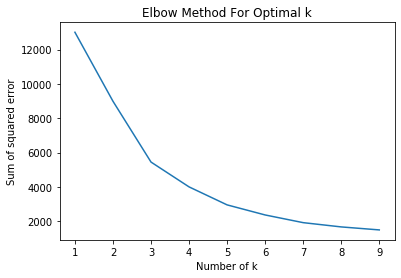

In [25]:
#Plot k value vs sum of squared error to see the optimal k for k-mens clustering (elbow method)
import matplotlib.pyplot as plt
plt.xlabel('Number of k')
plt.ylabel('Sum of squared error')
plt.plot(K,sse, )
plt.title('Elbow Method For Optimal k')
plt.show()

In [26]:
#From the plot above, choose the k = 4
km = KMeans(n_clusters=4, random_state=100)
pred = km.fit_predict(df_scaled)

df_rfm['Cluster'] = pred
df_rfm

,Frequency (Number),Monetary (Total),Recency (Day),Cluster
0,1,77183.60,326.0,0
1,182,4310.00,2.0,1
2,31,1797.24,75.0,1
3,73,1757.55,19.0,1
4,17,334.40,310.0,0
...,...,...,...,...
4333,10,180.60,278.0,0
4334,7,80.82,181.0,0
4335,12,178.05,8.0,1
4336,756,2094.88,4.0,1


In [27]:
#So, this is the information of cluster for each customerId
df_final['Cluster'] = pred
df_final

,CustomerID,Frequency (Number),Monetary (Total),Recency (Day),Cluster
0,12346.0,1,77183.60,326.0,0
1,12347.0,182,4310.00,2.0,1
2,12348.0,31,1797.24,75.0,1
3,12349.0,73,1757.55,19.0,1
4,12350.0,17,334.40,310.0,0
...,...,...,...,...,...
4333,18280.0,10,180.60,278.0,0
4334,18281.0,7,80.82,181.0,0
4335,18282.0,12,178.05,8.0,1
4336,18283.0,756,2094.88,4.0,1


In [28]:
#In order to more understand about the clustering result, create grouping tables by mean
round(df_rfm.groupby(['Cluster']).mean(),2)

,Frequency (Number),Monetary (Total),Recency (Day)
Cluster,,,
0,27.67,637.02,247.60
1,104.55,2090.57,41.44
2,5807.00,70925.29,2.00
3,826.83,190863.46,7.67


## Summary of Customer Segmentation
There are four clusters of customers in online retail which have caracteristics as below:  

1. Cluster 2 is the customers that often go to shopping (the average time since last order is 2 days ago), the total number and the total amount of purchases is the highest from other clusters.  
2. Cluster 3 is the opposite of cluster 2, the customers in this cluster is seldom go to shopping (the average time since last order is 249 - 250 days ago), the total number and the total amount of purchases is the lowest from other clusters.  
3. Cluster 0 is the customers that quite often go to shopping (the average time since last order is 15 days ago), the total number and the total amount of purchases is in the second place higher.  
4. Cluster 1 is the customers with third place higher in case of the total number and the total amount of purchases, the average time since last order is 43 - 44 days ago.  

After we know the caracteristic of each cluster, we can treate each cluster diffrently to gain the benefit for our business.  
For example, we can give discount for customers in cluster 2 and cluster 0, in order to keep their to shopping frequently and also give a premium fasility for customer in cluster 2.  
For customers in cluster 3 and cluster 1, we offer promo in order to increase their shooping time and value.

## Market Basket Analysis

In [29]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [41]:
df_pos['Country'].value_counts().head(10)

United Kingdom    485123
Germany             9040
France              8407
EIRE                7890
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1966
Portugal            1501
Australia           1182
Name: Country, dtype: int64

In [67]:
#I want to know the market basket analysis in 'Germany'
basket = df_pos[df_pos['Country']=='Germany'].groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket.head()

Description,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# Unit more then 1, will be set 1, else 0
def encode_unit(x):
    if x>=1:
        return 1
    else:
        return 0

basket_sets = basket.applymap(encode_unit)

#Delete item name 'POSTAGE', since it is error item name
basket_sets.drop('POSTAGE', axis = 1, inplace = True)

fequent_itemsets = apriori(basket_sets, min_support = 0.07, use_colnames = True)
rules = association_rules(fequent_itemsets, metric = 'lift', min_threshold = 1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ROUND SNACK BOXES SET OF4 WOODLAND ),(PLASTERS IN TIN WOODLAND ANIMALS),0.245077,0.137856,0.074398,0.303571,2.202098,0.040613,1.237951
1,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.137856,0.245077,0.074398,0.539683,2.202098,0.040613,1.640006
2,(ROUND SNACK BOXES SET OF4 WOODLAND ),(ROUND SNACK BOXES SET OF 4 FRUITS ),0.245077,0.157549,0.131291,0.535714,3.400298,0.092679,1.814509
3,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.157549,0.245077,0.131291,0.833333,3.400298,0.092679,4.529540
4,(ROUND SNACK BOXES SET OF4 WOODLAND ),(SPACEBOY LUNCH BOX ),0.245077,0.102845,0.070022,0.285714,2.778116,0.044817,1.256018
5,(SPACEBOY LUNCH BOX ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.102845,0.245077,0.070022,0.680851,2.778116,0.044817,2.365427


In [80]:
rules[rules['confidence'] >= 0.6]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(ROUND SNACK BOXES SET OF 4 FRUITS ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.157549,0.245077,0.131291,0.833333,3.400298,0.092679,4.529540
5,(SPACEBOY LUNCH BOX ),(ROUND SNACK BOXES SET OF4 WOODLAND ),0.102845,0.245077,0.070022,0.680851,2.778116,0.044817,2.365427


## Summary of Market Basket Analysis
Based on the result above, with confidence 60%, customer who buy SPACEBOY LUNCH BOX tend to buy ROUND SNACK BOXES SET OF4 WOODLAND and also customer who buy ROUND SNACK BOXES SET OF 4 FRUITS tend to buy ROUND SNACK BOXES SET OF4 WOODLAND.  
We can set confidence based on our need.